In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(pd.__version__)

0.23.4


In [3]:
%matplotlib widget

## Property Data

In [4]:
id_halo = '324123'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

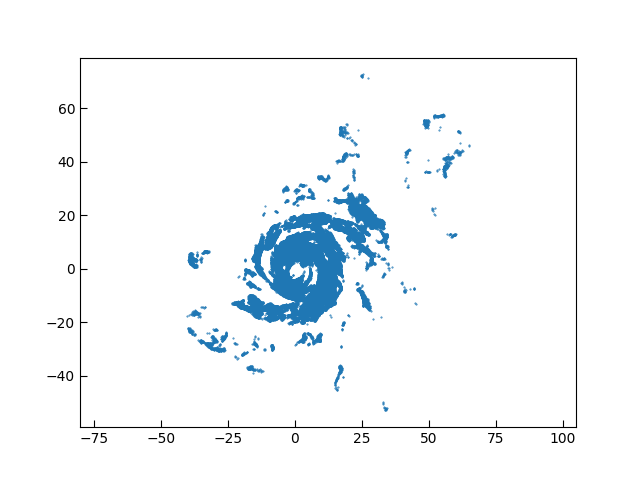

In [5]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [6]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


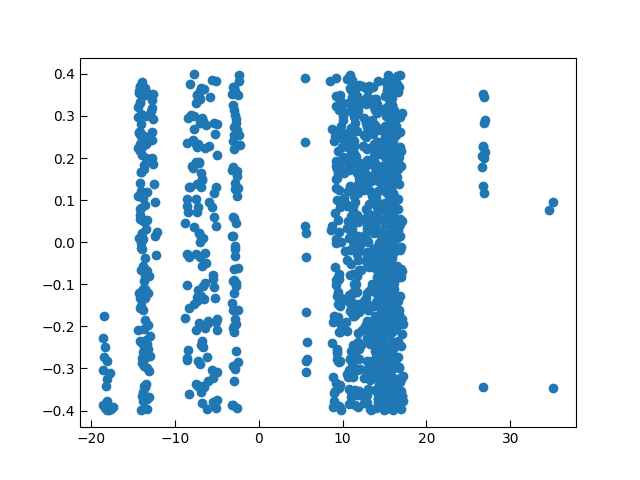

In [8]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


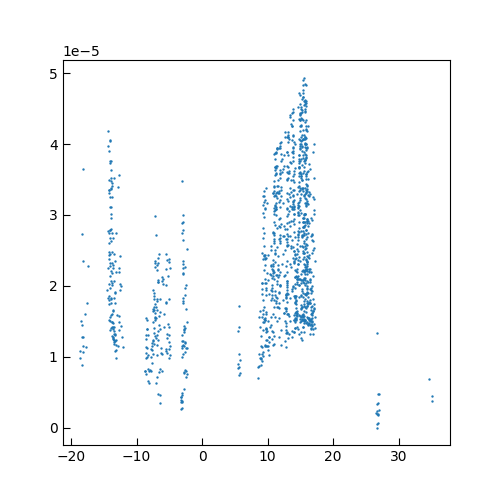

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [10]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

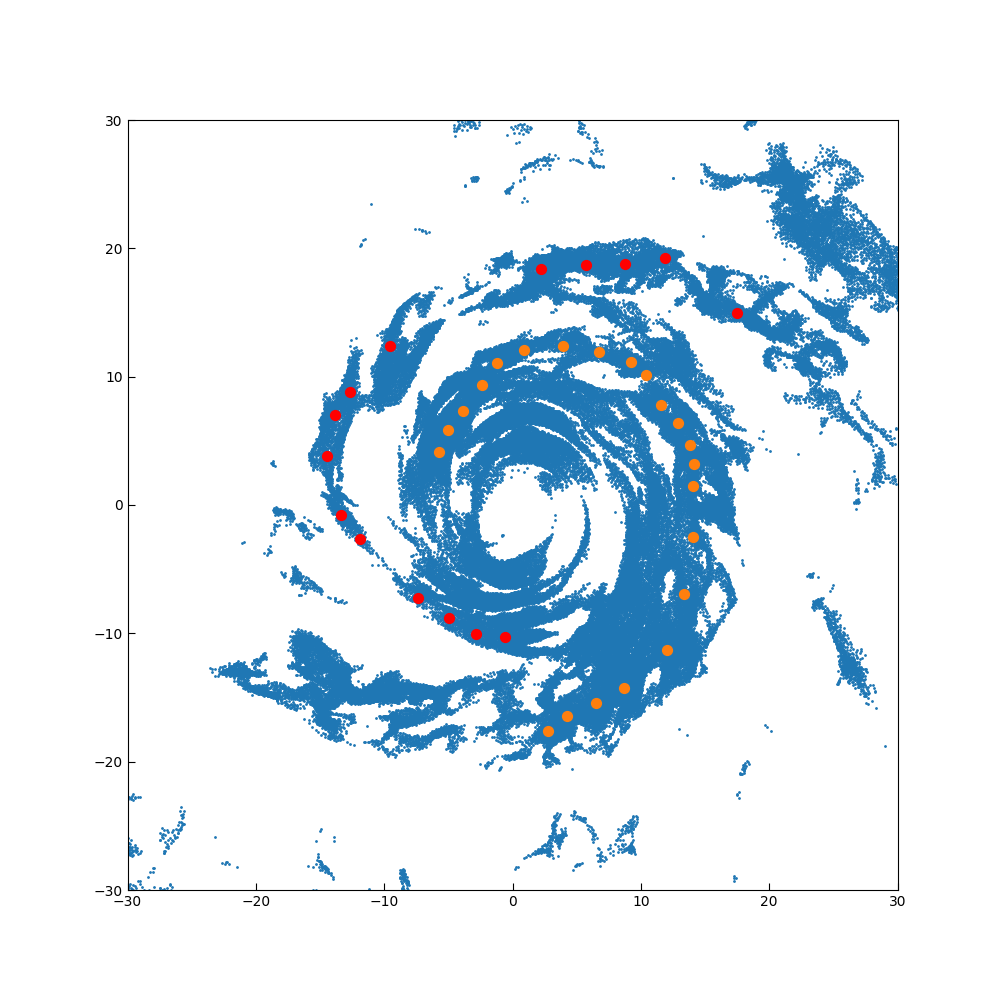

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 30
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [13]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [14]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [15]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [16]:
b = 0.3

In [17]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

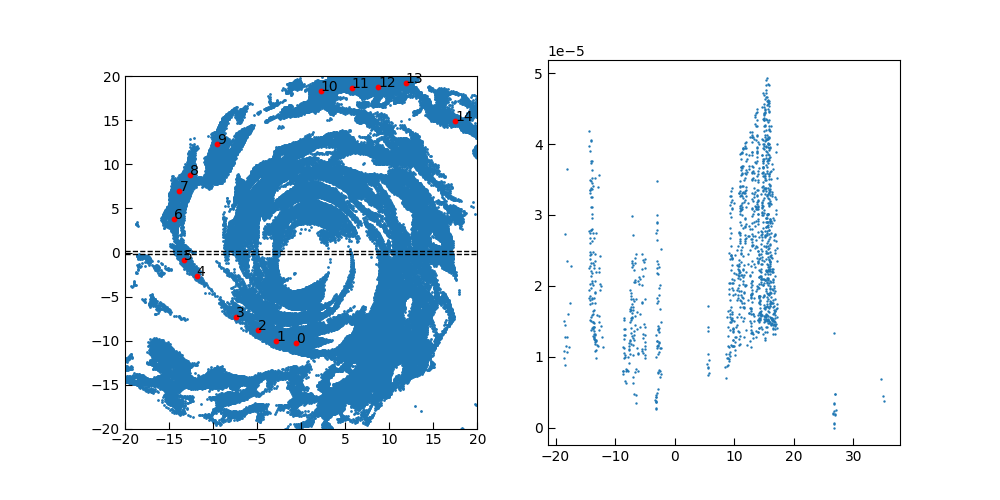

In [18]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

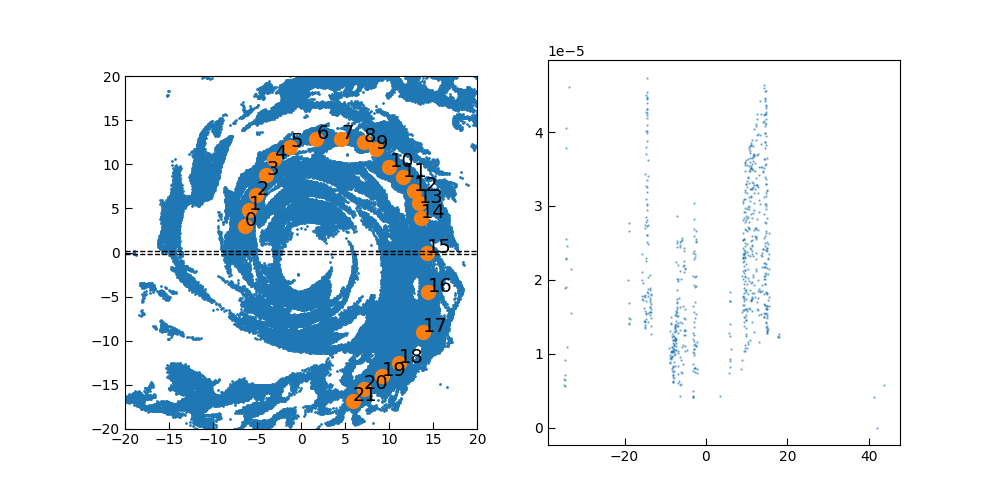

In [19]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 15
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [20]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [21]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [22]:
arm = df_arm2.copy(deep=True)

In [23]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-5.717532,4.103084,2,0,"({'x_rot': [-0.8324727903220112, -1.1439773968...","{'x_rot': [-0.8324727903220112, -1.14397739684...",2.519131,"{'x_rot': [7.037434137432456, 7.46715906912955...","{'x_rot': 7.037434137432456, 'y_rot': 1.776356...","{'x_band': [1.9523451947856452, 2.047201137689..."
1,-5.016234,5.817370,2,1,"({'x_rot': [-0.20820253988890447, -0.570706152...","{'x_rot': [-0.20820253988890447, -0.5707061521...",2.282380,"{'x_rot': [6.84112554178675, 7.681431925455632...","{'x_rot': 7.681431925455632, 'y_rot': 8.881784...","{'x_band': [2.1390703314867046, 2.086782823163..."
2,-3.847403,7.297890,2,2,"({'x_rot': [0.40017184479194934, 0.00778673050...","{'x_rot': [0.40017184479194934, 0.007786730505...",2.055962,"{'x_rot': [6.295977192726719, 7.48537684870336...","{'x_rot': 8.249951485429042, 'y_rot': 2.664535...","{'x_band': [2.120520511901875, 2.1454042513120..."
3,-2.366883,9.323864,2,3,"({'x_rot': [1.0135013699739157, 0.611304087868...","{'x_rot': [1.0135013699739157, 0.6113040878688...",1.819397,"{'x_rot': [5.383734097619338, 6.87276531036954...","{'x_rot': 9.619592964283392, 'y_rot': 1.332267...","{'x_band': [2.1119565455576734, 2.484495480415..."
4,-1.198052,11.038149,2,4,"({'x_rot': [1.3530965009755938, 0.955691847176...","{'x_rot': [1.3530965009755938, 0.9556918471765...",1.678911,"{'x_rot': [4.696070752808785, 6.32467464651827...","{'x_rot': 11.102975707326017, 'y_rot': 4.44089...","{'x_band': [2.160499747550254, 2.7124448854665..."
5,0.905844,12.051136,2,5,"({'x_rot': [1.7548102857924817, 1.375377071303...","{'x_rot': [1.7548102857924817, 1.3753770713032...",1.495771,"{'x_rot': [3.6629829543695496, 5.4250122276929...","{'x_rot': 12.08513306875997, 'y_rot': 6.661338...","{'x_band': [2.1418043755038036, 2.732062683684..."
6,3.944805,12.362825,2,6,"({'x_rot': [2.180839977218408, 1.8426743691493...","{'x_rot': [2.180839977218408, 1.84267436914933...",1.261923,"{'x_rot': [2.1708635196571393, 4.0172081918878...","{'x_rot': 12.976938081757911, 'y_rot': -1.3322...","{'x_band': [-2.487031750839222, 2.728452204177..."
7,6.750000,11.895292,2,7,"({'x_rot': [2.459796073952174, 2.1736914047738...","{'x_rot': [2.459796073952174, 2.17369140477387...",1.054654,"{'x_rot': [0.7468041155302223, 2.5838799225655...","{'x_rot': 13.677005399895187, 'y_rot': -8.8817...","{'x_band': [3.681699250156421, 3.6494063547540..."
8,9.243506,11.116071,2,8,"({'x_rot': [2.6153490261284564, 2.383675565474...","{'x_rot': [2.6153490261284564, 2.3836755654745...",0.877115,"{'x_rot': [-0.5007808848930129, 1.265719776853...","{'x_rot': 14.45715934409657, 'y_rot': 0.0}","{'x_band': [2.8068690916686405, 2.800625511099..."
9,10.412338,10.103084,2,9,"({'x_rot': [2.6695195686562205, 2.474214151256...","{'x_rot': [2.6695195686562205, 2.4742141512561...",0.770325,"{'x_rot': [-1.24612411652868, 0.45096171290618...","{'x_rot': 14.508242150686629, 'y_rot': 8.88178...","{'x_band': [2.8094476824384556, 2.840637073925..."


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Función para procesar antes del clicker y devolver el clicker
def process_before_clicker(arm, n, clicker):
    print(f"Processing point {n} before clicker...")
    
    fig, (ax, ax2) = plt.subplots(figsize=(7, 7), ncols=2)
    
    x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
    y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
    ax.axvline(x=x_tracing, lw=1, ls='--', color='red')
    
    x_band = arm.iloc[n].rotated_arm_profile['x_band']
    y_band = arm.iloc[n].rotated_arm_profile['y_band']
    ax.scatter(x_band, y_band, s=3, alpha=1)
    ax.set_xlim(x_tracing-2, x_tracing+2)
    
    # Clicker setup
    klicker = clicker(ax, ["limits"], markers=["o"], colors=['red'], markersize=2)
    
    x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
    y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
    x_coords = arm.iloc[n].rotation_coords['x_rot']
    y_coords = arm.iloc[n].rotation_coords['y_rot']
    
    ax2.scatter(x_coords, y_coords, s=3)
    ax2.scatter(x_tracing_all, y_tracing_all, s=100)
    for x, y, id in zip(x_tracing_all, y_tracing_all, arm.id):
        ax2.text(x, y, str(int(id)), fontsize=14)
    
    ax2.axvline(x=x_tracing, lw=1, ls='--', color='red')
    ax2.axhline(y=2, ls='--', lw=1, color='black')
    ax2.axhline(y=-2, ls='--', lw=1, color='black')
    
    ax2.set_xlim(x_tracing-3, x_tracing+3)
    ax2.set_ylim(-2.5, 2.5)
    
    # Muestra la gráfica para permitir interacción con el clicker
    plt.show()
    
    return klicker


IndexError: single positional indexer is out-of-bounds

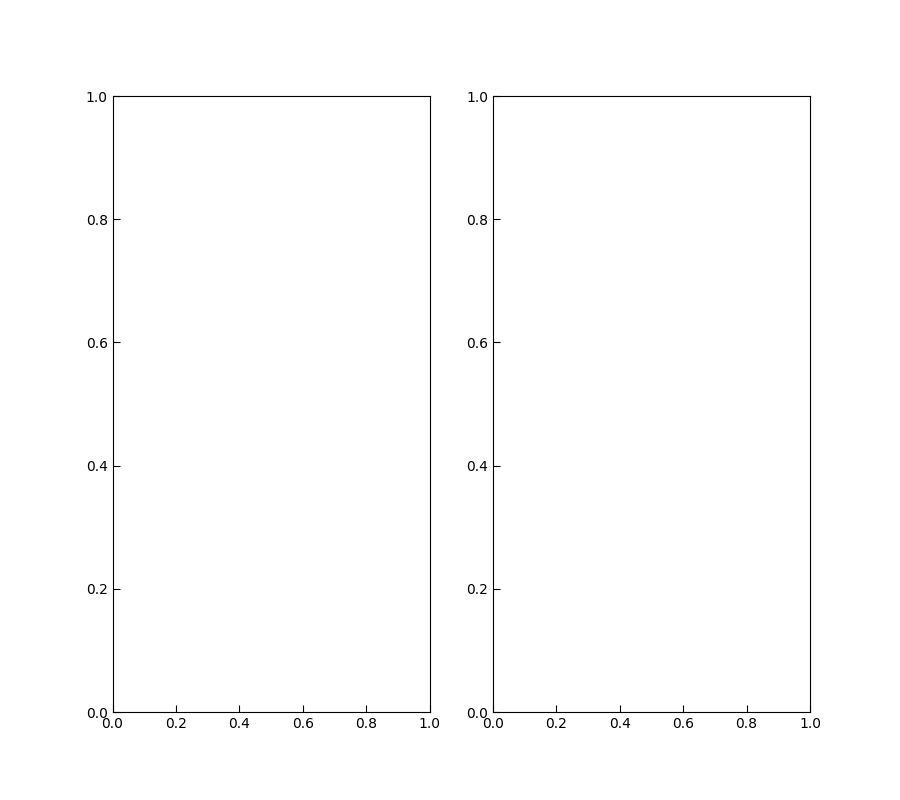

In [311]:
%matplotlib widget

n= 22 #n = 0 ---- 24 (total de puntos)
fig, (ax,ax2) = plt.subplots(figsize=(9,8), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2.5,x_tracing+2.5)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-4,4)

In [300]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [301]:
def get_asym_gaussian_fit_daniel(dict_lims, df_arm, n, bin_size):
    # Limits  
    limits = dict_lims['limits']
    limits_x = limits[:, 0]
    limits_y = limits[:, 1]
    
    # Interpolación de los límites
    f = interpolate.interp1d(limits_x, limits_y, kind='linear')

    # Datos de banda rotada
    x_band = df_arm.iloc[n].rotated_arm_profile['x_band']
    y_band = df_arm.iloc[n].rotated_arm_profile['y_band']

    # Filtrar puntos dentro de los límites definidos
    x_band_lim = x_band[(x_band >= np.min(limits_x)) & (x_band <= np.max(limits_x))]
    y_band_lim = y_band[(x_band >= np.min(limits_x)) & (x_band <= np.max(limits_x))]

    # Ajuste de los puntos que estén por debajo de la curva límite interpolada
    x_band_final = []
    y_band_final = []

    for x, y in zip(x_band_lim, y_band_lim):
        interpolated_value = f(x)
        if y <= interpolated_value:  # Cambiar "<" a "<=" para incluir los puntos en la curva
            x_band_final.append(x)
            y_band_final.append(y)

    # Convertir a numpy arrays
    x_band_final = np.array(x_band_final)
    y_band_final = np.array(y_band_final)

    # Verifica si tenemos suficientes puntos para ajustar
    if len(x_band_final) < 3:
        raise ValueError(f"No hay suficientes puntos para el ajuste en la región definida para n={n}")

    # Realizar el ajuste asimétrico gaussiano
    arm_fit = asym_gauss(x_band_final, y_band_final, np.min(x_band_final), np.max(x_band_final), bin_size)

    return {
        'arm_fit': arm_fit['model_fit'],
        'x_max': arm_fit['x_max'],
        'y_max': arm_fit['y_max']
    }


In [302]:
delta = 0.005
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(7.575485036374504e-11, 2.7970421339232203e-05)

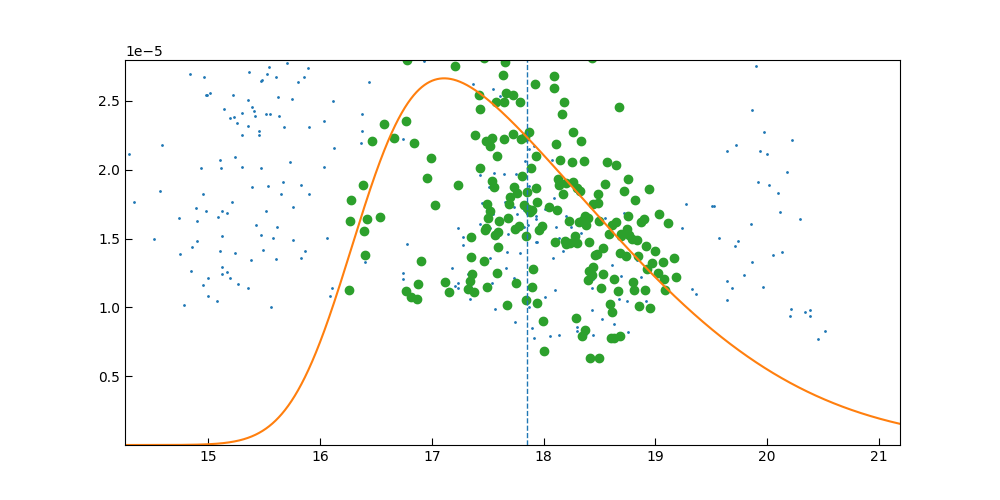

In [303]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [304]:
fractured = False

In [305]:
#df_params.tail()

In [306]:
df_params.tail(2)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
19,0.000154,18.358254,0.005,False,-6.202700,19.0,3.139218,0.000010,0.054577,1.497385,0.289556,"[14.66687937688731, 14.754934608939465, 14.768...",6.516234,"[1.7480992069432946e-05, 1.713707896174717e-05...",-15.455357
20,0.000130,18.241703,0.005,False,-3.147532,20.0,2.304157,0.000008,0.078988,0.906394,0.282534,"[15.34492874443608, 15.375297321011335, 15.392...",4.256494,"[1.1400400653899623e-05, 1.3717843086830967e-0...",-16.468344


In [307]:
## añadir n 

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [308]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 7.54771e-05
center                                                        16.3097
delta                                                           0.005
fractured                                                       False
gamma                                                          4.3352
id_tracing                                                         21
sigma                                                          2.0004
stderr_amplitude                                          4.96088e-06
stderr_center                                                0.106472
stderr_gamma                                                  2.06627
stderr_sigma                                                 0.176634
x                   [16.25564348052789, 16.269201389883854, 16.280...
x_tracing                                                     2.77597
y                   [1.1237740590772674e-05, 1.6285156405135748e-0...
y_tracing           

In [309]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



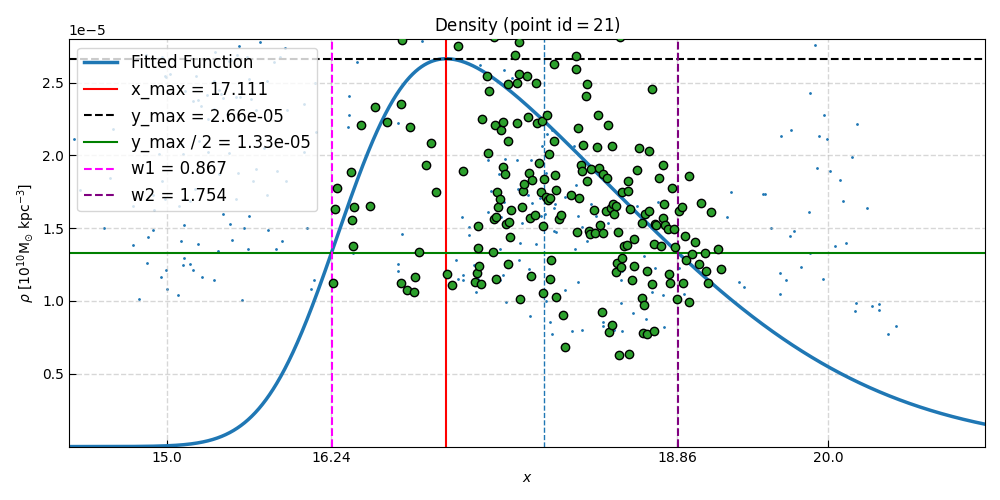

In [310]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

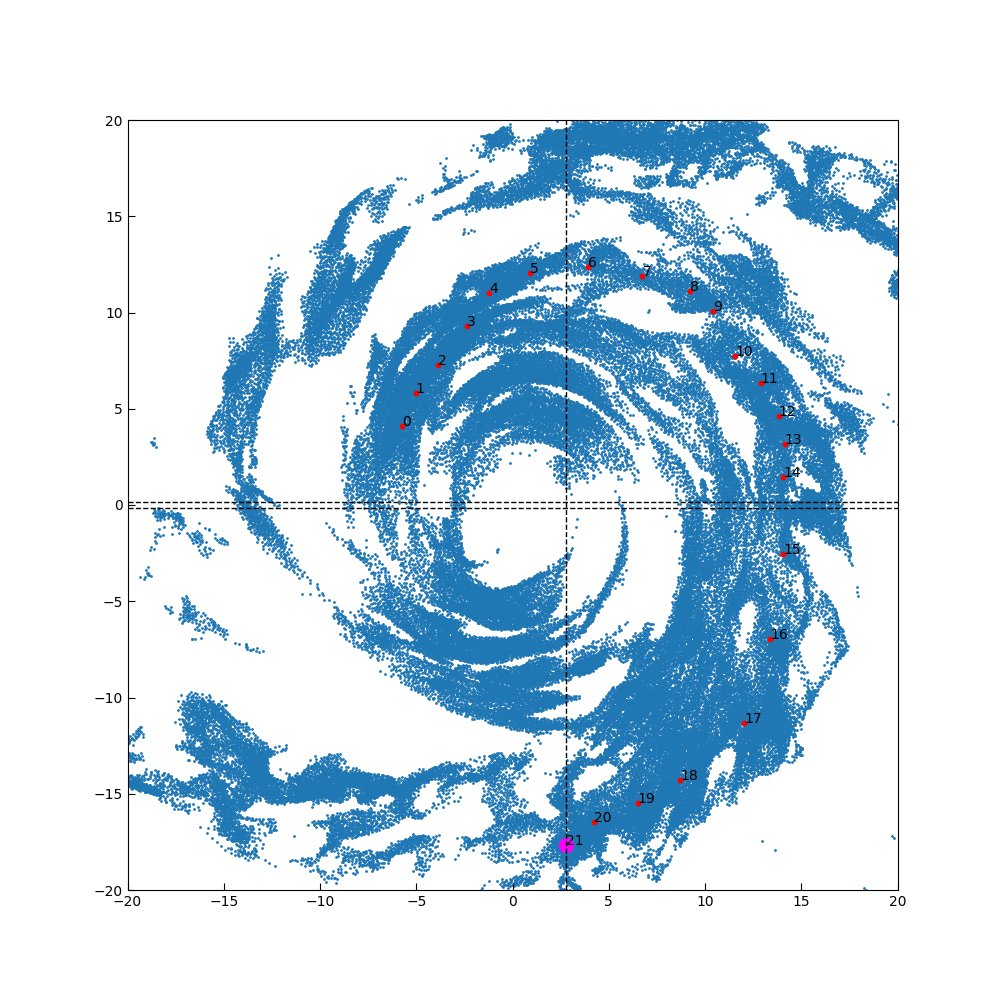

In [312]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [313]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

In [314]:
df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_.csv')

## arm 1

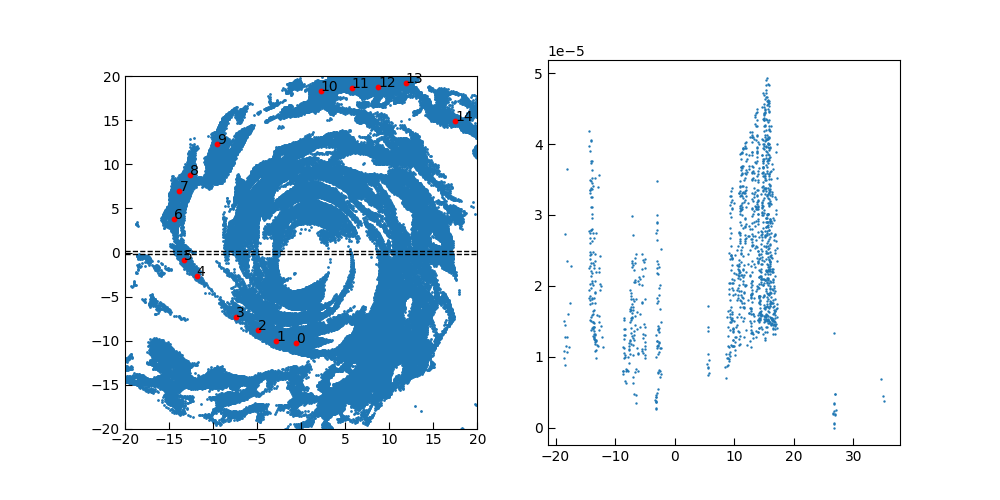

In [315]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [316]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [317]:
arm

,x,y,arm,id,rotation_info,rotation_coords,alpha,All_tracingPoints_rot,This_tracingPoint_rot,rotated_arm_profile
0,-0.574675,-10.312500,1,0,"({'x_rot': [-1.7149054559754229, -1.3329588802...","{'x_rot': [-1.7149054559754229, -1.33295888024...",4.656720,"{'x_rot': [10.328499793231867, 10.220827106924...","{'x_rot': 10.328499793231867, 'y_rot': 3.88578...","{'x_band': [-2.147196926682252, -2.72751169914..."
1,-2.834416,-10.078734,1,1,"({'x_rot': [-2.1245847165898013, -1.7790605305...","{'x_rot': [-2.1245847165898013, -1.77906053054...",4.438243,"{'x_rot': [10.082975614335071, 10.469708020560...","{'x_rot': 10.469708020560965, 'y_rot': 3.10862...","{'x_band': [2.4829005059877387, -2.72537119987..."
2,-4.938312,-8.831981,1,2,"({'x_rot': [-2.452808452102234, -2.16492552457...","{'x_rot': [-2.452808452102234, -2.164925524579...",4.202556,"{'x_rot': [9.281476962201134, 10.1802645975207...","{'x_rot': 10.118834034976523, 'y_rot': -4.4408...","{'x_band': [-3.680807259531097, -3.64964852791..."
3,-7.353896,-7.273539,1,3,"({'x_rot': [-2.665895297041727, -2.46723031501...","{'x_rot': [-2.665895297041727, -2.467230315011...",3.921497,"{'x_rot': [7.660452787844025, 9.10269716104954...","{'x_rot': 10.343314600487119, 'y_rot': 8.88178...","{'x_band': [-2.7925016179851596, -2.8099642607..."
4,-11.873377,-2.676136,1,4,"({'x_rot': [-2.46837368325635, -2.485124294437...","{'x_rot': [-2.46837368325635, -2.4851242944371...",3.363278,"{'x_rot': [2.82806256668432, 4.981103984025389...","{'x_rot': 12.171227476196613, 'y_rot': 3.55271...","{'x_band': [-2.915575292560998, -3.06593665342..."
5,-13.353896,-0.806006,1,5,"({'x_rot': [-2.262683380427636, -2.34380081430...","{'x_rot': [-2.262683380427636, -2.343800814300...",3.201877,"{'x_rot': [1.1949364391412538, 3.4364878838279...","{'x_rot': 13.378198220284604, 'y_rot': 3.77475...","{'x_band': [2.775751355924189, 2.4981274660258..."
6,-14.444805,3.791396,1,6,"({'x_rot': [-1.6939821688406664, -1.8938565317...","{'x_rot': [-1.6939821688406664, -1.89385653179...",2.884908,"{'x_rot': [-2.062241263019963, 0.1828105224731...","{'x_rot': 14.934091252316286, 'y_rot': 4.88498...","{'x_band': [2.134631136231557, -3.414579998805..."
7,-13.821429,6.986201,1,7,"({'x_rot': [-1.2167968986601225, -1.4854429667...","{'x_rot': [-1.2167968986601225, -1.48544296672...",2.673585,"{'x_rot': [-4.139179470466695, -2.016977406351...","{'x_rot': 15.486732913725795, 'y_rot': 4.44089...","{'x_band': [1.9542570003110604, 2.138455106649..."
8,-12.652597,8.778409,1,8,"({'x_rot': [-0.8731292654209192, -1.1805465254...","{'x_rot': [-0.8731292654209192, -1.18054652540...",2.535038,"{'x_rot': [-5.406376234311852, -3.416479463674...","{'x_rot': 15.399632696904494, 'y_rot': 3.55271...","{'x_band': [1.9546989164994477, 2.044640539765..."
9,-9.535714,12.362825,1,9,"({'x_rot': [-0.06135521681103251, -0.432828204...","{'x_rot': [-0.06135521681103251, -0.4328282040...",2.227804,"{'x_rot': [-7.814693580342825, -6.249454843203...","{'x_rot': 15.613112466500464, 'y_rot': -2.6645...","{'x_band': [2.150690871816631, 2.0046406245633..."


(-2.5, 2.5)

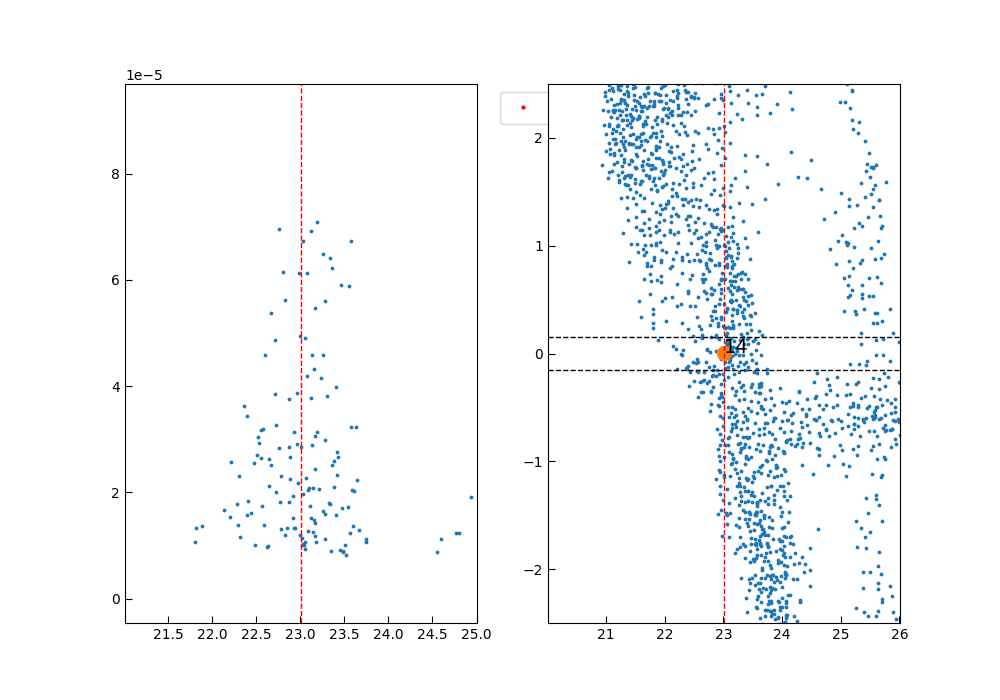

In [466]:
n= 14 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [454]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [455]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(0.0, 6.65603974311597e-05)

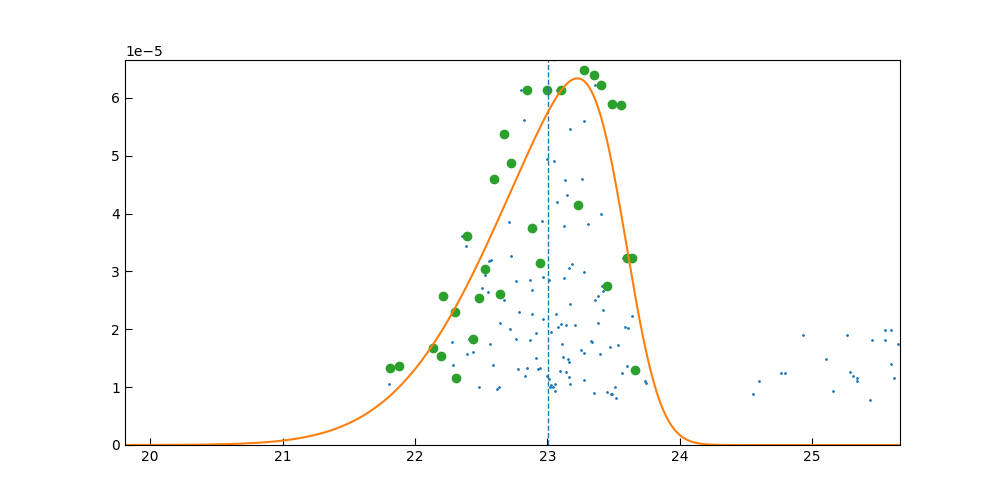

In [456]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [457]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [458]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 7.79918e-05
center                                                        23.5848
delta                                                            0.05
fractured                                                       False
gamma                                                        -3.97908
id_tracing                                                         14
sigma                                                        0.856246
stderr_amplitude                                          5.33225e-06
stderr_center                                               0.0428843
stderr_gamma                                                  1.97988
stderr_sigma                                                0.0979512
x                   [21.809333141624176, 21.881317535346977, 22.13...
x_tracing                                                     17.5032
y                   [1.3325664944827368e-05, 1.367554948853958e-05...
y_tracing           

In [459]:
df_params

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
0,0.000047,9.279418,0.05,False,6.179990,0.0,1.315170,0.000004,0.045540,3.027758,0.166032,"[9.195870943384389, 9.245276387828238, 9.28715...",-0.574675,"[1.1601577666314614e-05, 1.5646316630690358e-0...",-10.312500
1,0.000069,9.505440,0.05,False,1.259071,1.0,1.204320,0.000009,0.707770,2.387243,0.792543,"[8.819071961135856, 9.010166578563613, 9.01820...",-2.834416,"[7.472269256266808e-06, 9.183958385622233e-06,...",-10.078734
2,0.000083,10.073588,0.05,False,-0.062420,2.0,1.063962,0.000016,1160.424124,1373.489001,57.799666,"[9.269330964066059, 9.315312826914028, 9.36131...",-4.938312,"[1.219135311552658e-05, 2.706794294705104e-05,...",-8.831981
3,0.000046,9.233571,0.05,False,6.623711,3.0,1.168867,0.000004,0.042171,3.033831,0.169003,"[9.011420319888817, 9.129148577858174, 9.16930...",-7.353896,"[9.124540643391795e-06, 1.0616978700370333e-05...",-7.273539
4,0.000032,12.538581,0.05,False,-8.474159,4.0,0.691587,0.000005,0.051294,12.994737,0.153629,"[11.689761188744255, 11.744951024020054, 11.80...",-11.873377,"[1.7783888945442595e-05, 1.6439922511796055e-0...",-2.676136
5,0.000044,13.899967,0.05,False,-3.697499,5.0,1.112769,0.000003,0.045185,1.552826,0.147163,"[12.468237850431318, 12.590973250647338, 12.66...",-13.353896,"[1.097901613218841e-05, 1.8739526630687204e-05...",-0.806006
6,0.000102,13.919510,0.05,False,3.900705,6.0,2.049036,0.000012,0.121368,2.833320,0.449471,"[13.862815009196249, 13.926469602282063, 13.97...",-14.444805,"[1.7559239951765074e-05, 1.8797118856108247e-0...",3.791396
7,0.000134,16.463065,0.05,False,-6.464163,7.0,2.556182,0.000021,0.079943,3.843434,0.579388,"[14.195795998275866, 14.306444508974147, 14.39...",-13.821429,"[2.4579349978475016e-05, 2.8300191602373402e-0...",6.986201
8,0.000053,15.927812,0.05,False,-2.425101,8.0,0.877037,0.000003,0.066470,0.992084,0.115754,"[14.180125530637646, 14.246847001014064, 14.29...",-12.652597,"[1.4523889290292414e-05, 1.349143840699266e-05...",8.778409
9,0.000076,13.782664,0.05,False,10.697875,9.0,2.240745,0.000007,0.091125,8.090927,0.282226,"[13.762426274864277, 13.841500312311705, 13.91...",-9.535714,"[1.1658402460825702e-05, 1.6778698660133264e-0...",12.362825


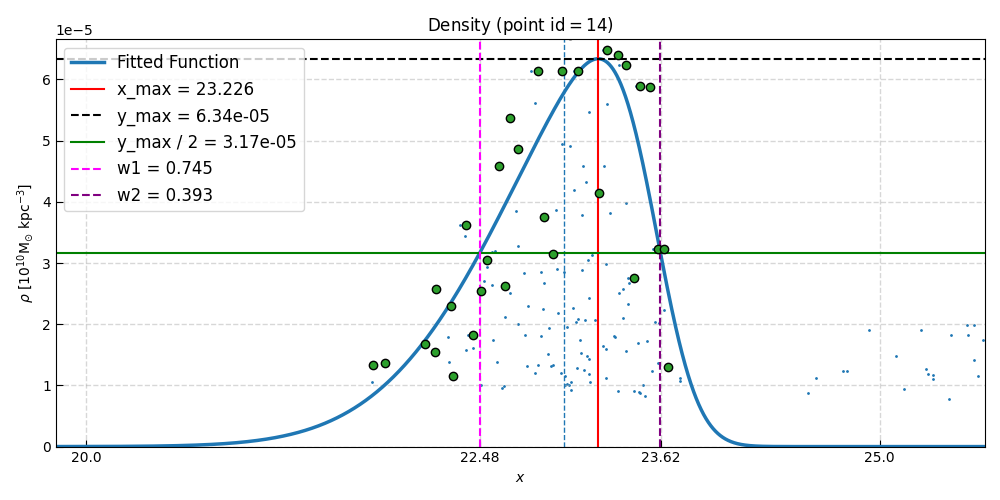

In [460]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

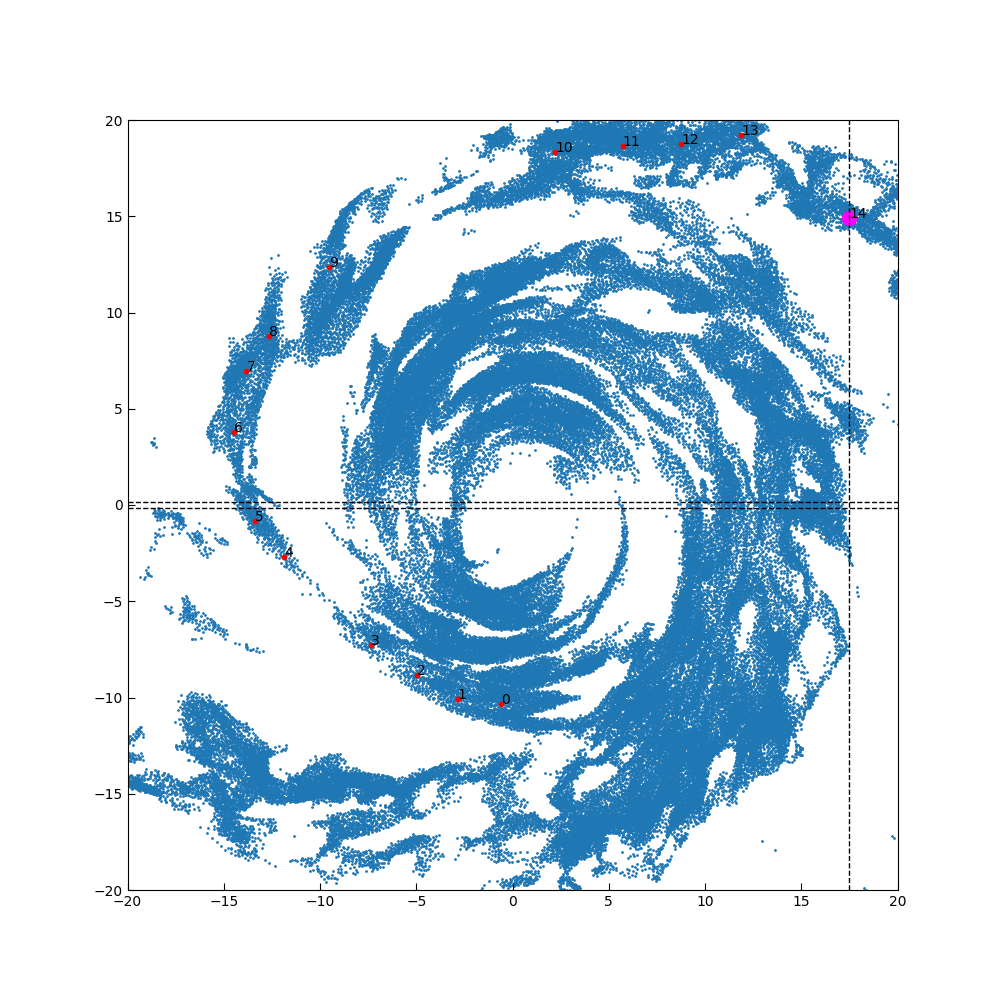

In [461]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [463]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')

In [464]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}__.csv', index = False)
